In [1]:
## https://docs.pymc.io/notebooks/GLM-logistic.html
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fmin_powell
from scipy import integrate

import theano as thno
import theano.tensor as T

In [2]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init='adapt_diag')

    return models, traces

def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('income ~ educ + hours + age ' + ' '.join(['+ np.power(age,{})'.format(j)
                                     for j in range(2,k+1)])).strip()

In [3]:
raw_data = pd.read_csv('adult_data', header=None,
                       names=['age', 'workclass', 'fnlwgt',
                              'education-categorical', 'educ',
                              'marital-status', 'occupation',
                              'relationship', 'race', 'sex',
                              'captial-gain', 'capital-loss',
                              'hours', 'native-country',
                              'income'])

In [4]:
raw_data.head(10)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [5]:
data = raw_data[~pd.isnull(raw_data['income'])]
data[data['native-country']==" United-States"].sample(5)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
5073,48,Private,192894,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
11083,49,Local-gov,193249,Assoc-acdm,12,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,<=50K
17217,24,Private,190709,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,65,United-States,<=50K
9405,45,Local-gov,175958,9th,5,Never-married,Other-service,Own-child,White,Male,0,0,40,United-States,<=50K
7120,47,Self-emp-not-inc,107231,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,35,United-States,>50K


In [6]:
income = 1 * (data['income'] == " >50K")
data = data[['age', 'educ', 'hours']]

# Scale age by 10, it helps with model convergence.
data['age'] = data['age']/10.
data['age2'] = np.square(data['age'])
data['income'] = income

In [7]:
income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [8]:
data.head()

,age,educ,hours,age2,income
0,3.9,13,40,15.21,0
1,5.0,13,13,25.00,0
2,3.8,9,40,14.44,0
3,5.3,7,40,28.09,0
4,2.8,13,40,7.84,0


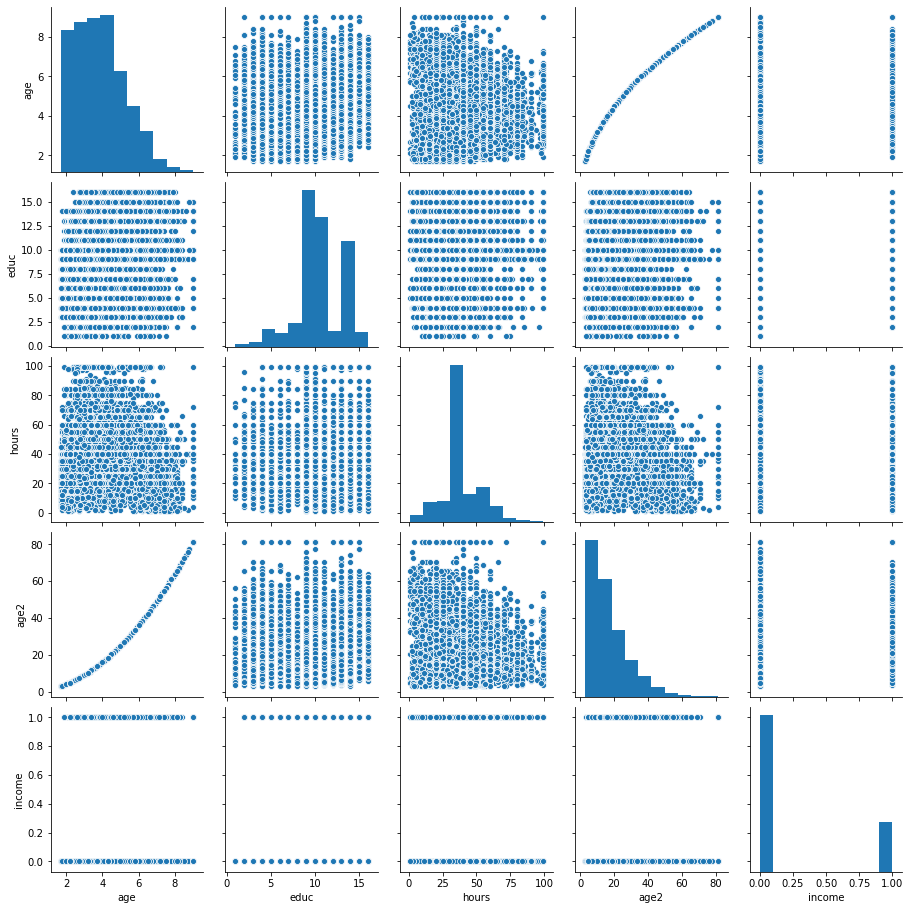

In [9]:
g = seaborn.pairplot(data)

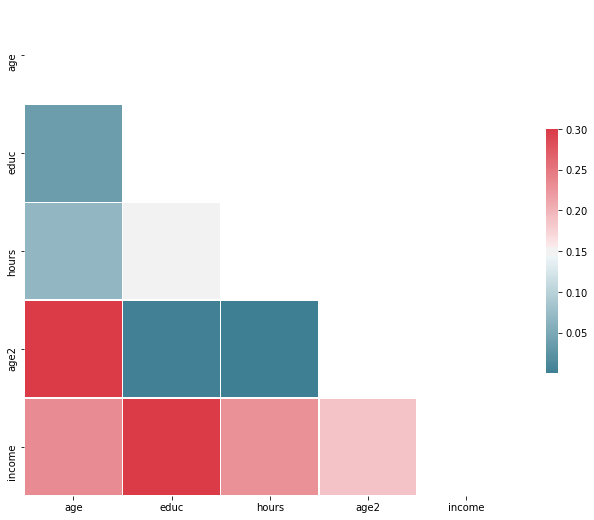

In [10]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

In [11]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('income ~ age + age2 + educ + hours',
                            data,
                            family=pm.glm.families.Binomial())
    trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hours, educ, age2, age, Intercept]
Sampling 4 chains: 100%|██████████| 8000/8000 [59:32<00:00,  2.24draws/s]  
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b500d4b90>,
      dtype=object)

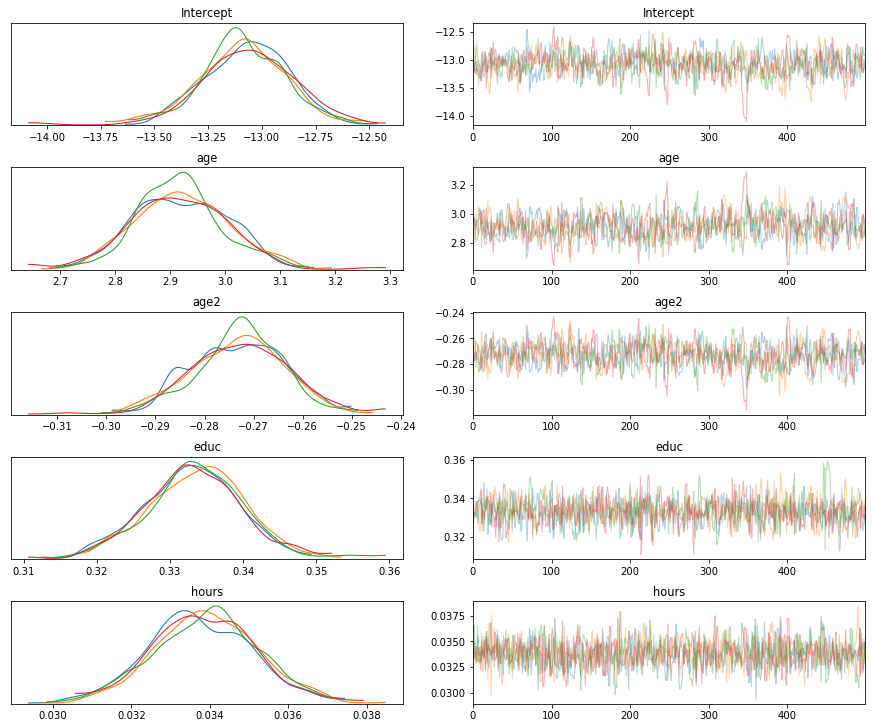

In [13]:
import arviz as az
az.plot_trace(trace[500:])

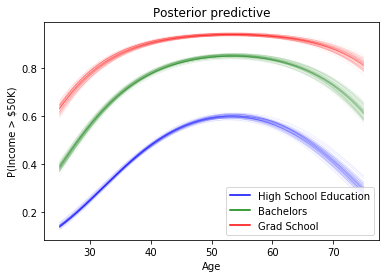

In [15]:
def lm_full(trace, age, educ, hours):
    shape = np.broadcast(age, educ, hours).shape
    x_norm = np.asarray([np.broadcast_to(x, shape)
                         for x in [age/10., educ, hours]])
    return 1 / (1 + np.exp(-(trace['Intercept'] +
                             trace['age']*x_norm[0] +
                             trace['age2']*(x_norm[0]**2) +
                             trace['educ']*x_norm[1] +
                             trace['hours']*x_norm[2])))

# Linear model with hours == 50 and educ == 12
lm = lambda x, samples: lm_full(samples, x, 12., 50.)

# Linear model with hours == 50 and educ == 16
lm2 = lambda x, samples: lm_full(samples, x, 16., 50.)

# Linear model with hours == 50 and educ == 19
lm3 = lambda x, samples: lm_full(samples, x, 19., 50.)

# Plot the posterior predictive distributions of P(income > $50K) vs. age
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    25, 75, 1000), lm=lm, samples=100, color="blue", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    25, 75, 1000), lm=lm2, samples=100, color="green", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    25, 75, 1000), lm=lm3, samples=100, color="red", alpha=.15)

import matplotlib.lines as mlines
blue_line = mlines.Line2D(['lm'], [], color='b', label='High School Education')
green_line = mlines.Line2D(['lm2'], [], color='g', label='Bachelors')
red_line = mlines.Line2D(['lm3'], [], color='r', label='Grad School')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show()

